In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import norm

In [ ]:
hotel_data = pd.read_csv('hotel_bookings.csv').sample(n=5000, random_state=42)
hotel_data.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
30946,Resort Hotel,0,203,2016,December,49,2,2,5,2,...,No Deposit,250.0,NaN,0,Transient,66.8,0,0,Check-Out,2016-12-09
40207,City Hotel,1,82,2015,July,29,16,0,3,2,...,No Deposit,9.0,NaN,0,Transient,76.5,0,0,Canceled,2015-07-16
103708,City Hotel,0,25,2016,December,53,27,0,3,3,...,No Deposit,220.0,NaN,0,Transient-Party,60.0,0,1,Check-Out,2016-12-30
85144,City Hotel,0,1,2016,March,11,9,0,1,1,...,No Deposit,9.0,NaN,0,Transient-Party,95.0,0,0,Check-Out,2016-03-10
109991,City Hotel,0,70,2017,April,16,16,2,2,2,...,No Deposit,9.0,NaN,0,Transient,108.0,0,0,Check-Out,2017-04-20


In [ ]:
B = 400
hotel_sample_200 = hotel_data.sample(n=200, random_state=50)

In [ ]:
hotel_encoder = LabelEncoder()
hotel_sample_200['hotel_encoded'] = \
          hotel_encoder.fit_transform(hotel_sample_200['hotel'])
hotel_data['hotel_encoded'] = \
          hotel_encoder.fit_transform(hotel_data['hotel'])
year_encoder = LabelEncoder()
hotel_sample_200['arrival_date_year_encoded'] = \
          year_encoder.fit_transform(hotel_sample_200['arrival_date_year'])
hotel_data['arrival_date_year_encoded'] = \
          year_encoder.fit_transform(hotel_data['arrival_date_year'])

X = pd.concat([
    hotel_sample_200['lead_time'],
    hotel_sample_200['hotel_encoded'],
    hotel_sample_200['arrival_date_year_encoded']
], axis=1)
X_cols = X.columns
X_orig = pd.concat([
    hotel_data['lead_time'],
    hotel_data['hotel_encoded'],
    hotel_data['arrival_date_year_encoded']
], axis=1)

x = np.array(np.hstack([np.ones((X.shape[0], 1)), X]))
x_orig = np.array(np.hstack([np.ones((X_orig.shape[0], 1)), X_orig]))
C = np.linalg.inv(x.T @ x) # since matrix is invertible
C_orig = np.linalg.inv(x_orig.T @ x_orig)

Y = hotel_sample_200['adr']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)
residuals = Y_test - Y_pred
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("\nModel Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

coefficients = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)
print(f"\nIntercept: {model.intercept_:.2f}")


Model Performance:
Mean Squared Error: 2216.31
R-squared: 0.05

Model Coefficients:
                           Coefficient
lead_time                    -0.048748
hotel_encoded               -13.920499
arrival_date_year_encoded    14.329177

Intercept: 92.48


:## Part A - Linear Regression
***Research question:***
1. The influence of lead_time, hotel and year of arrival variables have on the variable adr

## Section 1 - Calculating CI's

### Section 1.a - Normal approx where s.e depends on the variance

---

matrix of the estimated β

In [ ]:
n=200
p=4

# Extract relevant features and calculate beta hat.
X = hotel_sample_200[['lead_time','hotel_encoded','arrival_date_year_encoded']].to_numpy()
y = hotel_sample_200['adr'].to_numpy()
X = np.c_[np.ones(X.shape[0]), X]
xTx = np.matmul(X.T,X)
xTx_inv = np.linalg.inv(xTx)
xTy = np.matmul(X.T,y)
ols_sampled = np.matmul(xTx_inv,xTy)

# Build CI using normal approx. and beta's variance matrix.
X_all = hotel_sample_200[['lead_time','hotel_encoded','arrival_date_year_encoded']].to_numpy()
y_all = hotel_sample_200['adr'].to_numpy()
X_all = np.c_[np.ones(X_all.shape[0]), X_all]
xTx = np.matmul(X_all.T,X_all)
xTx_inv = np.linalg.inv(xTx)
xTy = np.matmul(X_all.T,y_all)
ols_all = np.matmul(xTx_inv,xTy)

C = np.linalg.inv(X.T@X)
e = y - np.dot(X, ols_sampled)
var_estimate = 1/(n-p)*sum([x**2 for x in e])
norm_quantile = stats.norm.ppf(0.975)
CI_normal_matrix = []
for i, variable in zip(range(ols_sampled.shape[0]), ['bias', 'lead_time', 'hotel_encoded', 'arrival_date_year_encoded']):
  std_estimate = (var_estimate*C[i][i])**(1/2)
  CI_beta_i = [ols_sampled[i] - norm_quantile*std_estimate, ols_sampled[i] + norm_quantile*std_estimate]
  CI_normal_matrix.append(CI_beta_i)
  print(f"CI for beta_{i} is: {CI_beta_i}")
  print(f"Is the CI for {variable} (beta_{i}) in the sample data contains the estimator of the original data: {ols_all[i] >= CI_beta_i[0] and ols_all[i] <= CI_beta_i[1]}")
  print()


CI for beta_0 is: [68.96485887090364, 104.70012629931477]
Is the CI for bias (beta_0) in the sample data contains the estimator of the original data: True

CI for beta_1 is: [-0.10120803718082803, 0.031891926648260335]
Is the CI for lead_time (beta_1) in the sample data contains the estimator of the original data: True

CI for beta_2 is: [-22.617481255495328, 6.545536710903965]
Is the CI for hotel_encoded (beta_2) in the sample data contains the estimator of the original data: True

CI for beta_3 is: [6.966972770965427, 26.92761752322643]
Is the CI for arrival_date_year_encoded (beta_3) in the sample data contains the estimator of the original data: True



### Section 1.b - Normal approx where s.e estimator is based on **bootstrap**

In [ ]:
#Build CI using normal approx. and bootstrap.
B = 400
beta_0 = []
beta_1 = []
beta_2 = []
beta_3 = []

for b in range(B):
  sampled_df = hotel_sample_200.sample(n, replace=True)
  x_sampled = sampled_df[['lead_time', 'hotel_encoded', 'arrival_date_year_encoded']].to_numpy()
  x_sampled = np.c_[np.ones(x_sampled.shape[0]), x_sampled]
  y_sampled = sampled_df['adr'].to_numpy()
  xTy_sampled = np.matmul(x_sampled.T, y_sampled)
  C_sampled = np.linalg.inv(x_sampled.T@x_sampled)
  ols_estimator_sampled = np.matmul(C_sampled, xTy_sampled)
  beta_0.append(ols_estimator_sampled[0])
  beta_1.append(ols_estimator_sampled[1])
  beta_2.append(ols_estimator_sampled[2])
  beta_3.append(ols_estimator_sampled[3])

betas_se = [np.std(beta_0), np.std(beta_1), np.std(beta_2), np.std(beta_3)]
normal_bootstrap_ci = []

for i, variable in zip(range(len(betas_se)), ['bias', 'lead_time', 'hotel_encoded', 'arrival_date_year_encoded']):
  CI = [ols_sampled[i] - norm_quantile*betas_se[i], ols_sampled[i] + norm_quantile*betas_se[i]]
  normal_bootstrap_ci.append(CI)
  print(f"CI for beta_{i} is: {CI}")
  print(f"Is the CI of {variable} (beta_{i}) in the sample data contains the estimator of the original data: {ols_all[i] >= CI[0] and ols_all[i] <= CI[1]}\n")


CI for beta_0 is: [71.901923004164, 101.76306216605441]
Is the CI of bias (beta_0) in the sample data contains the estimator of the original data: True

CI for beta_1 is: [-0.09383181782543931, 0.024515707292871607]
Is the CI of lead_time (beta_1) in the sample data contains the estimator of the original data: True

CI for beta_2 is: [-26.31073868335032, 10.238794138758958]
Is the CI of hotel_encoded (beta_2) in the sample data contains the estimator of the original data: True

CI for beta_3 is: [7.254378898839514, 26.640211395352345]
Is the CI of arrival_date_year_encoded (beta_3) in the sample data contains the estimator of the original data: True



### Section 1.c - CI using boostrap with the pivot method

In [ ]:
# Build CI using pivotal method bootstrap.
quantiles_dict = {}
for i, beta_list in enumerate(zip([beta_0, beta_1, beta_2, beta_3])):
  quantiles_dict[f"beta_{i}"] = (np.quantile(beta_list, 0.975), np.quantile(beta_list, 0.025))

# calculate the pivotal cofidence intervals
pivotal_bootstrap_ci = []
for i, variable in zip(range(len(quantiles_dict)), ['bias', 'lead_time', 'hotel_encoded', 'arrival_date_year_encoded']):
  ci = [2*ols_sampled[i] - quantiles_dict[f"beta_{i}"][0], 2*ols_sampled[i] - quantiles_dict[f"beta_{i}"][1]]
  pivotal_bootstrap_ci.append(ci)
  print(f'CI for {variable} is {ci}')
  print(f'Is the CI for {variable} (beta_{i}) in the sample data contains the estimator the original data: {ols_all[i] >= ci[0] and ols_all[i] <= ci[1]} \n')

CI for bias is [73.60603267140371, 102.44966010410488]
Is the CI for bias (beta_0) in the sample data contains the estimator the original data: True 

CI for lead_time is [-0.09599124259943392, 0.02099732786687336]
Is the CI for lead_time (beta_1) in the sample data contains the estimator the original data: True 

CI for hotel_encoded is [-26.97613912862316, 9.489816716929994]
Is the CI for hotel_encoded (beta_2) in the sample data contains the estimator the original data: True 

CI for arrival_date_year_encoded is [6.1508744232520804, 25.487272041847064]
Is the CI for arrival_date_year_encoded (beta_3) in the sample data contains the estimator the original data: True 



### Section 1.d - CI using bootstrap with the percentile method

In [ ]:
# Build CI using quantiles method bootstrap.
quantiles_bootstrap_ci = []

for i, variable in zip(range(len(quantiles_dict)), ['bias', 'lead_time', 'hotel_encoded', 'arrival_date_year_encoded']):
  ci = [quantiles_dict[f"beta_{i}"][1], quantiles_dict[f"beta_{i}"][0]]
  quantiles_bootstrap_ci.append(ci)
  print(f'CI for {variable} is {ci}')
  print(f'Is the CI of {variable} (beta_{i}) in the sample data contains the estimator the original data: {ols_all[i] >= ci[0] and ols_all[i] <= ci[1]}\n')

CI for bias is [71.21532506611354, 100.0589524988147]
Is the CI of bias (beta_0) in the sample data contains the estimator the original data: True

CI for lead_time is [-0.09031343839944106, 0.026675132066866225]
Is the CI of lead_time (beta_1) in the sample data contains the estimator the original data: True

CI for hotel_encoded is [-25.561761261521355, 10.9041945840318]
Is the CI of hotel_encoded (beta_2) in the sample data contains the estimator the original data: True

CI for arrival_date_year_encoded is [8.407318252344794, 27.743715870939777]
Is the CI of arrival_date_year_encoded (beta_3) in the sample data contains the estimator the original data: True



## Section 2 - compare CI intervals of β from section 1 and if they contain the CI on all of the data

In [ ]:
#RAQUE'S VERSION, I THINK THIS IS WHAT WE ACTUALLY HAVE TO DO:
# Build dict of CI lengths per method and beta, and convert it to a table.
ci_lengths = {"coefficient": ["Bias (beta_0)", "lead_time (beta_1)", "Hotel (beta_2)", "arrival_date_year (beta_3)"], "normal_matrix": [], "normal_bootstrap": [], "pivot_bootstrap": [], "quantile_bootstrap": []}
for i in range(p):
  ci_lengths["normal_matrix"].append(round(CI_normal_matrix[i][1] - CI_normal_matrix[i][0], 4))
  ci_lengths["normal_bootstrap"].append(round(normal_bootstrap_ci[i][1] - normal_bootstrap_ci[i][0], 4))
  ci_lengths["pivot_bootstrap"].append(round(pivotal_bootstrap_ci[i][1] - pivotal_bootstrap_ci[i][0], 4))
  ci_lengths["quantile_bootstrap"].append(round(quantiles_bootstrap_ci[i][1] - quantiles_bootstrap_ci[i][0], 4))

ci_lengths_df = pd.DataFrame(ci_lengths)
ci_lengths_df = ci_lengths_df.set_index("coefficient", drop=True)
ci_lengths_df

,normal_matrix,normal_bootstrap,pivot_bootstrap,quantile_bootstrap
coefficient,,,,
Bias (beta_0),35.7353,29.8611,28.8436,28.8436
lead_time (beta_1),0.1331,0.1183,0.1170,0.1170
Hotel (beta_2),29.1630,36.5495,36.4660,36.4660
arrival_date_year (beta_3),19.9606,19.3858,19.3364,19.3364


In [ ]:
#COEFFICIENTS FOR THE WHOLE DATA:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Load and sample the dataset
hotel_data = pd.read_csv('hotel_bookings.csv').sample(n=5000, random_state=42)

# Encode categorical variables
hotel_encoder = LabelEncoder()
hotel_data['hotel_encoded'] = hotel_encoder.fit_transform(hotel_data['hotel'])

year_encoder = LabelEncoder()
hotel_data['arrival_date_year_encoded'] = year_encoder.fit_transform(hotel_data['arrival_date_year'])

# Prepare the feature matrix (X) and target variable (Y)
X = pd.concat([
    hotel_data['lead_time'],
    hotel_data['hotel_encoded'],
    hotel_data['arrival_date_year_encoded']
], axis=1)

Y = hotel_data['adr']

# Split the dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Evaluate the model
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

# Output model performance
print("\nModel Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Output the coefficients
coefficients = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
print("\nModel Coefficients:")
print(coefficients)
print(f"\nIntercept: {model.intercept_:.2f}")



Model Performance:
Mean Squared Error: 2258.22
R-squared: 0.06

Model Coefficients:
                           Coefficient
lead_time                    -0.032644
hotel_encoded               -11.561505
arrival_date_year_encoded    13.476457

Intercept: 92.59


COMPARE THE LENGTH OF EACH CI FOR EACH METHOD:
PIVOT METHOD AND QUANTILE METHOD HAVE THE SAME LENGTH FOR ALL COEFFICIENTS WHICH MAKES SENSE SINCE WHEN CALCULATING THE LENGTH OF EACH INTERVAL MATHEMATICALLY THEY BOTH ARE $\hat{\beta}^*_{1-\frac{\alpha}{2}} - \hat{\beta}^*_{\frac{\alpha}{2}}$

MOREOVER, FOR ALL THE METHODS THE ESTIMATORS OF BETA FOR THE WHOLE SET ARE INSIDE OF THE INTERVAL.

CI for each variable on all the data (5000 tuples)

In [ ]:
cov_matrix = C_orig
sigma_squared = np.var(residuals)
se_beta = []
for j in range(cov_matrix.shape[0]):
    C_ii = cov_matrix[j, j]
    se_beta_j = np.sqrt(sigma_squared * C_ii)
    se_beta.append(se_beta_j)

n = len(X_train)
p = x.shape[1]
df = n - p

t_value = stats.t.ppf(0.975, df)
coefficients = pd.DataFrame(model.coef_, index=X.columns, columns=['Coefficient'])
intercept_row = pd.DataFrame({'Coefficient': [model.intercept_]}, index=['Intercept'])
coefficients = pd.concat([intercept_row, coefficients])

coefficients['SE'] = se_beta

ci_lower = coefficients['Coefficient'] - t_value * coefficients['SE']
ci_upper = coefficients['Coefficient'] + t_value * coefficients['SE']
print("\nConfidence Intervals for Each Coefficient:")
for param, lower, upper in zip(coefficients.index, ci_lower, ci_upper):
    print(f"{param}: ({lower:.2f}, {upper:.2f})")


Confidence Intervals for Each Coefficient:
Intercept: (89.62, 95.56)
lead_time: (-0.04, -0.02)
hotel_encoded: (-14.30, -8.82)
arrival_date_year_encoded: (11.64, 15.31)


Comparison: #ToDo

## Section 3- 100 data points not in the sample_200

In [ ]:
remaining_data_indices = hotel_data.index.difference(hotel_sample_200.index)
sampled_indices = np.random.choice(remaining_data_indices, size=1000, replace=False)
hotel_sample_100 = hotel_data.loc[sampled_indices]
hotel_sample_100 = hotel_sample_100[['adr', 'lead_time', 'hotel_encoded', 'arrival_date_year_encoded']]

In [ ]:
X_new = hotel_sample_100[['lead_time', 'hotel_encoded', 'arrival_date_year_encoded']]
y_new = hotel_sample_100['adr'].values

predictions = model.predict(X_new)
residuals = model.predict(hotel_sample_100[['lead_time', 'hotel_encoded', 'arrival_date_year_encoded']]) - hotel_sample_100['adr'].values
n_bootstrap = B
n_points = len(X_new)
bootstrap_predictions = np.zeros((n_points, n_bootstrap))

for i in range(n_bootstrap):
    bootstrap_errors = np.random.choice(residuals, size=n_points, replace=True)
    bootstrap_predictions[:, i] = predictions + bootstrap_errors

lower_bounds = np.percentile(bootstrap_predictions, 2.5, axis=1)
upper_bounds = np.percentile(bootstrap_predictions, 97.5, axis=1)

in_interval = (y_new >= lower_bounds) & (y_new <= upper_bounds)
coverage_pct = np.mean(in_interval) * 100

print(f"Percentage of actual values falling within 95% prediction intervals: {coverage_pct:.1f}%")
print(f"Average interval width: {np.mean(upper_bounds - lower_bounds):.2f}")

Percentage of actual values falling within 95% prediction intervals: 90.9%
Average interval width: 172.28


PERCENTAGE OF CONFIDENCE INTERVALS THAT CONTAIN THE REAL VALUE OF Ynew IS 91.6% WHICH IS INDEED VERY CLOSE TO 95%

# Section 3.d


We could do something similar to what we learned in TA 5, Question 1. In this case, we also need to account for the variance of the prediction itself. We can randomly generate a bootstrap sample similarly to what we did in the previous step.

We then choose a method that uses the normal distribution and the variance correction of the bootstrap. The variance of the error (epsilon) will not be calculated. Recall that in Question 1 of Exercise 1, the training variance was not calculated under noise variance.

The final prediction will be:

$$
\sigma^2_{\epsilon} X_{\text{new}} C X_{\text{new}}^T + \sigma^2_{\epsilon}
$$






# Part B - Tests

Q1- Is the distribution of adr values bigger in resort hotels than adr values in city hotels?

In [ ]:
hotel_sample_200 = hotel_data.sample(n=200, random_state=50)
hotel_resort_200 = hotel_sample_200[hotel_sample_200['hotel'] == 'Resort Hotel']
hotel_city_200 = hotel_sample_200[hotel_sample_200['hotel'] == 'City Hotel']

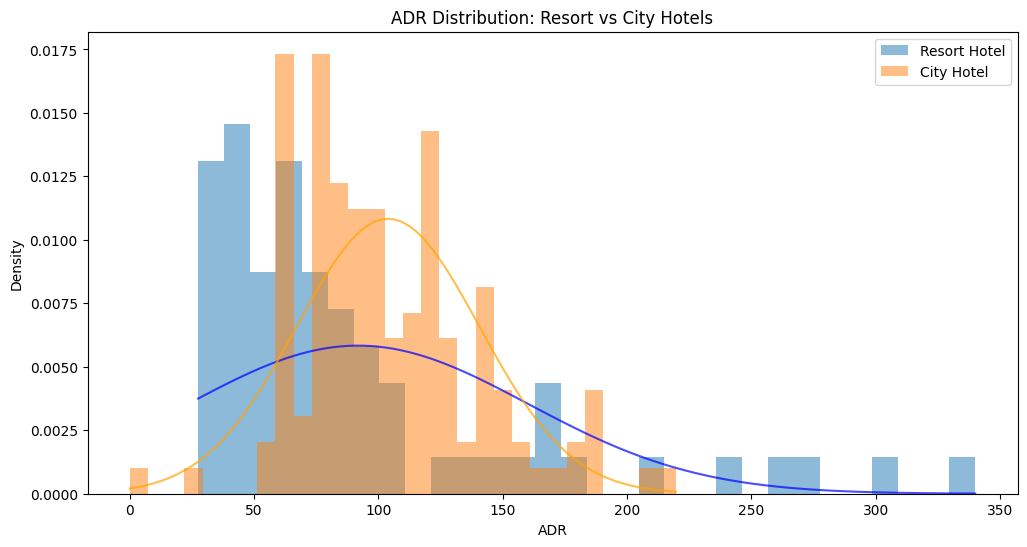

Difference in means (δ = μ1 - μ2): -12.05

Normality Tests (Shapiro-Wilk):
Resort Hotel: ShapiroResult(statistic=0.7636299244410121, pvalue=5.99696612355722e-09)
City Hotel: ShapiroResult(statistic=0.9578616374695416, pvalue=0.0003815721556226547)

Skewness:
Resort Hotel: 1.8716368272579083
City Hotel: 0.6254859635752107

Kurtosis:
Resort Hotel: 3.052428152813567
City Hotel: 0.5910755542838229


In [ ]:
plt.figure(figsize=(12, 6))

plt.hist(hotel_resort_200['adr'], bins=30, alpha=0.5, label='Resort Hotel', density=True)
plt.hist(hotel_city_200['adr'], bins=30, alpha=0.5, label='City Hotel', density=True)

x_resort = np.linspace(hotel_resort_200['adr'].min(), hotel_resort_200['adr'].max(), 100)
x_city = np.linspace(hotel_city_200['adr'].min(), hotel_city_200['adr'].max(), 100)

plt.plot(x_resort, stats.norm.pdf(x_resort, mu1, hotel_resort_200['adr'].std()),
         color='blue', alpha=0.7)
plt.plot(x_city, stats.norm.pdf(x_city, mu2, hotel_city_200['adr'].std()),
         color='orange', alpha=0.7)

plt.title('ADR Distribution: Resort vs City Hotels')
plt.xlabel('ADR')
plt.ylabel('Density')
plt.legend()
plt.show()

print(f"Difference in means (δ = μ1 - μ2): {delta:.2f}")

print("\nNormality Tests (Shapiro-Wilk):")
print("Resort Hotel:", stats.shapiro(hotel_resort_200['adr']))
print("City Hotel:", stats.shapiro(hotel_city_200['adr']))

print("\nSkewness:")
print("Resort Hotel:", stats.skew(hotel_resort_200['adr']))
print("City Hotel:", stats.skew(hotel_city_200['adr']))

print("\nKurtosis:")
print("Resort Hotel:", stats.kurtosis(hotel_resort_200['adr']))
print("City Hotel:", stats.kurtosis(hotel_city_200['adr']))

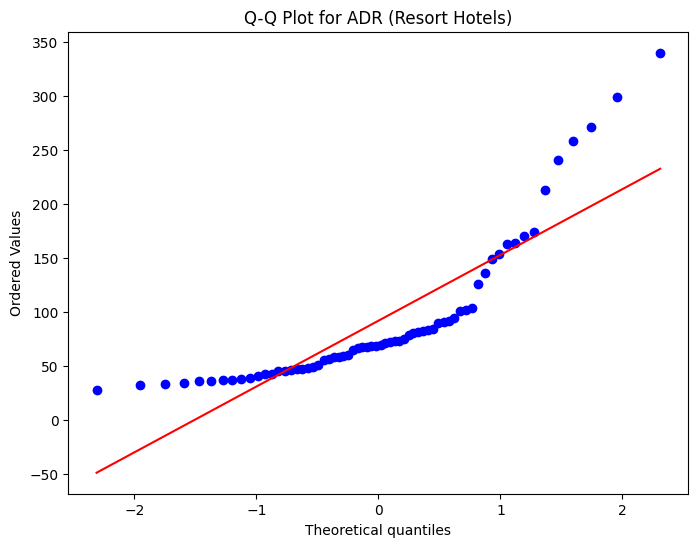

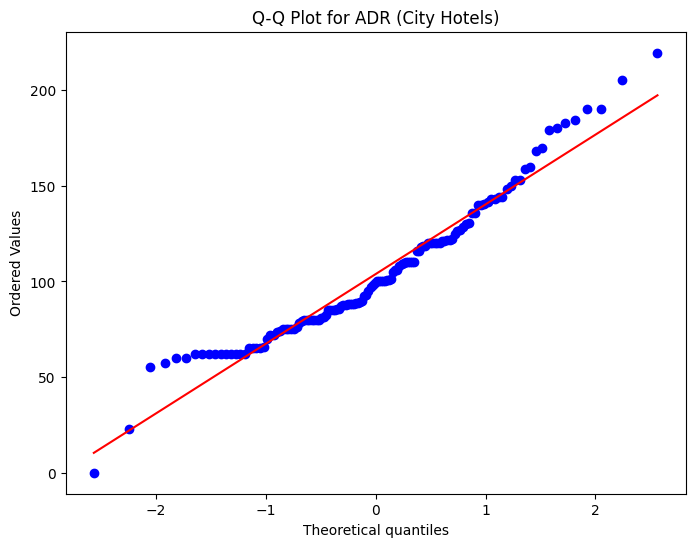

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Extract ADR values
resort_adr = hotel_resort_200['adr']
city_adr = hotel_city_200['adr']

# Q-Q plot for Resort Hotels
plt.figure(figsize=(8, 6))
stats.probplot(resort_adr, dist="norm", plot=plt)
plt.title("Q-Q Plot for ADR (Resort Hotels)")
plt.show()

# Q-Q plot for City Hotels
plt.figure(figsize=(8, 6))
stats.probplot(city_adr, dist="norm", plot=plt)
plt.title("Q-Q Plot for ADR (City Hotels)")
plt.show()


3.a

In [ ]:

mu1 = hotel_resort_200['adr'].mean()
mu2 = hotel_city_200['adr'].mean()
delta = mu1 - mu2

print(f"mu1 estimator: {round(mu1,4)}")
print(f"mu2 estimator: {round(mu2,4)}")
print(f"delta estimator: {round(delta,4)}")

mu1 estimator: 91.8091
mu2 estimator: 103.8627
delta estimator: -12.0536


According to the previous plots, we can't assume normal distribution for adr with respect to city nor resort hotels. Therefore, mu1, mu2 and by consequence also delta are not MLEs.

3b.

In [ ]:
n1 = len(hotel_resort_200)
n2 = len(hotel_city_200)

s1_squared = hotel_resort_200['adr'].var(ddof=1)
s2_squared = hotel_city_200['adr'].var(ddof=1)

se_delta = np.sqrt(s1_squared / n1 + s2_squared / n2)

confidence_level = 0.95
z = norm.ppf(1 - (1 - confidence_level) / 2)

lower_bound = delta - z * se_delta
upper_bound = delta + z * se_delta

print(f"95% Confidence Interval for delta: ({lower_bound:.2f}, {upper_bound:.2f})")


95% Confidence Interval for delta: (-29.69, 5.58)


3c.

In [ ]:
hotel_resort_all = hotel_data[hotel_data['hotel'] == 'Resort Hotel']
hotel_city_all = hotel_data[hotel_data['hotel'] == 'City Hotel']
mu1 = hotel_resort_all['adr'].mean()
mu2 = hotel_city_all['adr'].mean()
delta_all = mu1 - mu2

n1 = len(hotel_resort_all)
n2 = len(hotel_city_all)

s1_squared = hotel_resort_all['adr'].var(ddof=1)
s2_squared = hotel_city_all['adr'].var(ddof=1)

se_delta = np.sqrt(s1_squared / n1 + s2_squared / n2)

confidence_level = 0.95
z = norm.ppf(1 - (1 - confidence_level) / 2)

lower_bound = delta_all - z * se_delta
upper_bound = delta_all + z * se_delta

print(f"95% Confidence Interval for delta: ({lower_bound:.2f}, {upper_bound:.2f})")


95% Confidence Interval for delta: (-13.61, -7.33)


We can see that the CI for the delta estimator on all the data is a subset of the CI interval for the sample of 200 tuples.

### Section 3.d - wald and permutation tets

Wald Test: (one sided, fails since as we showed earlier not all the data in this case distributes normally)

In [ ]:
resort_adr = hotel_resort_200['adr'].values
city_adr = hotel_city_200['adr'].values

obs_delta = np.mean(resort_adr) - np.mean(city_adr)
se_delta = np.sqrt(np.var(resort_adr, ddof=1) / len(resort_adr) +
                   np.var(city_adr, ddof=1) / len(city_adr))
z = obs_delta / se_delta
p_value = 1 - norm.cdf(z)
alpha = 0.05

print(f"Wald Test Statistic (z): {z:.2f}")
print(f"One-Sided P-value: {p_value:.4f}")

if p_value < alpha:
    print("Reject the null hypothesis.")
else:
    print("Fail to reject the null hypothesis.")


Wald Test Statistic (z): -1.34
One-Sided P-value: 0.9098
Fail to reject the null hypothesis.


Permutation Test:

In [ ]:
resort_adr = hotel_resort_200['adr'].values
city_adr = hotel_city_200['adr'].values

obs_delta = np.mean(resort_adr) - np.mean(city_adr)

combined = np.concatenate([resort_adr, city_adr])

# Permutation test parameters
num_permutations = 10000
perm_deltas = []

for _ in range(num_permutations):
    np.random.shuffle(combined)

    perm_resort = combined[:len(resort_adr)]
    perm_city = combined[len(resort_adr):]
    perm_delta = np.mean(perm_resort) - np.mean(perm_city)
    perm_deltas.append(perm_delta)

perm_deltas = np.array(perm_deltas)
p_value = np.mean(np.abs(perm_deltas) >= np.abs(obs_delta))

print(f"Observed Difference in Means: {obs_delta:.2f}")
print(f"P-value from Permutation Test: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The distribution of 'adr' values is significantly different between the two hotel types.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in the distribution of 'adr' values between the two hotel types.")


Observed Difference in Means: -12.05
P-value from Permutation Test: 0.1061
Fail to reject the null hypothesis: There is no significant difference in the distribution of 'adr' values between the two hotel types.


# Section 4 - Percentile 0.5

In [ ]:
hotel_sample_200 = hotel_data.sample(n=200, random_state=50)
hotel_resort_200 = hotel_sample_200[hotel_sample_200['hotel'] == 'Resort Hotel']
hotel_city_200 = hotel_sample_200[hotel_sample_200['hotel'] == 'City Hotel']
mu1 = hotel_resort_200['adr'].median()
mu2 = hotel_city_200['adr'].median()
delta_med = mu1 - mu2

print("mu1:", mu1)
print("mu2:", mu2)
print("delta:", delta_med)

mu1: 68.875
mu2: 99.725
delta: -30.849999999999994


Is the estimator you received a MLE?
I think NOT BUT WE SHOULD CHECK.


4.B) C.I FOR DELTA

In [ ]:
print(f"The CI is: {CI}")
print(f"delta estimator is in CI? {bool(delta_med <= CI[1] and delta_med >= CI[0])}")


The CI is: [7.254378898839514, 26.640211395352345]
delta estimator is in CI? False


4.C) CI FOR ALL THE DATA

In [ ]:
hotel_resort_all = hotel_data[hotel_data['hotel'] == 'Resort Hotel']
hotel_city_all = hotel_data[hotel_data['hotel'] == 'City Hotel']
mu1 = hotel_resort_all['adr'].median()
mu2 = hotel_city_all['adr'].median()
delta_med_all = mu1 - mu2

print("mu1:", mu1)
print("mu2:", mu2)
print("delta:", delta_med_all)


mu1: 74.8
mu2: 99.0
delta: -24.200000000000003


THIS DELTA IS ALSO NOT IN THE CI OF THE PREVIOUS SECTION.

4)D)

In [ ]:
import random
n=200
# Permutations test
num_city = hotel_city_200.count()[0]
counter = 0

for b in range(B):
  group_1_indices = random.sample(range(n), num_city)

  group_2_indices = [i for i in range(n) if i not in group_1_indices]

  group1_adr = hotel_sample_200.iloc[group_1_indices, :]['adr'].values
  group2_adr = hotel_sample_200.iloc[group_2_indices, :]['adr'].values

  mu_group1 = np.median(group1_adr)
  mu_group2 = np.median(group2_adr)
  delta_b = mu_group1 - mu_group2

  if delta <= delta_b:
    counter += 1

p_value = counter/B
print(f"Permutation test:")
print(f"Reject H0? {p_value < 0.05}")


<ipython-input-37-adcc16b2b82f>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_city = hotel_city_200.count()[0]


Permutation test:
Reject H0? False


4)E)

**WALD TEST:**
As we saw in previous sections, the estimator of delta is not an MLE so it's not asimptotically normal, thus, we can't use the wald test.

**T - TEST**:
LET'S CHECK IF THE ASSUMPTIONS OF THE TEST ARE TRUE:
- EQUAL AND UNKOWN VARIANCES:
  FROM WHAT WE SAW IN QUESTION 3)D) THE VARIANCES OF BOT CATEGORIES (CITY AND RESORT) ARE EQUAL.

- INDEPENDENT SAMPLES:
  THE VALUES OF ADR FOR CITY HOTELS IS INDEPENDENT OF THE VALUES OF ADR FOR RESORT HOTELS, THEREFORE THEY ARE INDEPENDENT SAMPLES.

- THE OBSERVATIONS HAVE A NORMAL DISTRIBUTION:
  WE SAW THAT THIS IS NOT TRUE IN THE PREVIOUS SECTIONS.

SINCE THE LAST ASSUMPTION IS NOT TRUE, WE CANNOT USE T-TEST.



# Section 5

In [ ]:
from scipy.stats import shapiro, norm

# Permutations test on Group 1 using resampling
num_city = hotel_city_200.count()[0]
num_resort = hotel_resort_200.count()[0]
counter = 0
hotel_sample_200['adr_rank'] = hotel_sample_200['adr'].rank()
S1_original = np.sum(hotel_sample_200[hotel_sample_200['hotel'] == "City Hotel"]['adr_rank'].values)

for b in range(B):
  group_1_indices = random.sample(range(n), num_city)
  group_2_indices = [i for i in range(n) if i not in group_1_indices]
  current_S1 = np.sum(hotel_sample_200.iloc[group_1_indices, :]['adr_rank'].values)
  if current_S1 >= S1_original:
    counter += 1

p_value = counter/B
print(f"Reject H0 by resampling? {p_value <= 0.05}")


# Checking if we can use normal approximation
# Normality Test (Shapiro-Wilk)
stat_resort, p_resort = shapiro(resort_adr)
stat_city, p_city = shapiro(city_adr)

print(f"Shapiro-Wilk Test p-value for Resort Hotel: {p_resort:.4f}")
print(f"Shapiro-Wilk Test p-value for City Hotel: {p_city:.4f}")

normal_resort = p_resort > 0.05
normal_city = p_city > 0.05

if normal_resort and normal_city:
  print("Both hotel types have normal distributions of 'adr' values, proceeding with asymptotic normality.")
  N = num_city + num_resort
  n = num_city
  m = num_resort
  expected = n*(N+1)/2
  var = m*n*(N+1)/12
  statistic = (S1_original-expected)/(var**(1/2))
  print(f"Reject H0 by Normal approximation? {statistic >= stats.norm.ppf(0.95)}")
else:
  print("We cannot use asymptotic normality")



<ipython-input-44-38f53c5221e4>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_city = hotel_city_200.count()[0]
<ipython-input-44-38f53c5221e4>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_resort = hotel_resort_200.count()[0]


Reject H0 by resampling? True
Shapiro-Wilk Test p-value for Resort Hotel: 0.0000
Shapiro-Wilk Test p-value for City Hotel: 0.0004
We cannot use asymptotic normality


In this permutation test we reject H0 but in the test with sampling we don't reject H0.
The first test focuses on differences in medians and fails to reject the null hypothesis, indicating no significant difference in central tendency between the groups. The second test, using ranks, is more sensitive to overall distribution differences and detects a significant difference, leading to rejection of the null hypothesis. This highlights that different test statistics measure distinct aspects of the data, and the choice of test depends on what we aim to compare

## Part 6

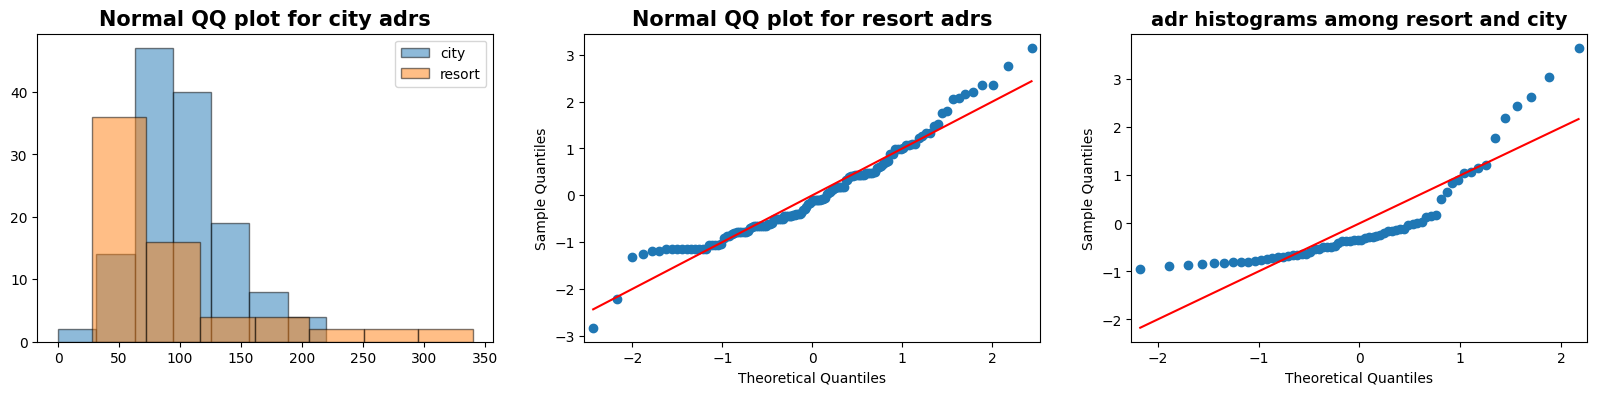

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,4))

hotel_city_200['adr'].hist(edgecolor = "black", grid = False, alpha = 0.5, label = "city", ax = ax1, bins=7)
hotel_resort_200['adr'].hist(edgecolor = "black", grid = False, alpha = 0.5, label = "resort", ax = ax1, bins = 7)

plt.title("adr histograms among resort and city", fontweight = "bold", fontsize = 14)

ax1.legend()

hotel_city_200 = hotel_sample_200[hotel_sample_200['hotel'] == "City Hotel"]
hotel_resort_200 = hotel_sample_200[hotel_sample_200['hotel'] == "Resort Hotel"]

city_adr = hotel_city_200['adr'].values

qqplot(city_adr,norm,fit=True,line="s", ax=ax2)
ax1.set_title("Normal QQ plot for city adrs", fontsize = 15, fontweight = "bold")

resort_adr = hotel_resort_200['adr'].values
qqplot(resort_adr,norm,fit=True,line="s", ax=ax3)

ax2.set_title("Normal QQ plot for resort adrs", fontsize = 15, fontweight = "bold")
plt.show()

Despite some visual differences in the histograms of 'adr' for city and resort hotels, the statistical analyses present a mixed picture. While the tests comparing means (Question 3d) and medians (Question 4d) failed to reject the null hypothesis, suggesting no significant difference in central tendency, the permutation test in Question 5 did reject the null hypothesis. This indicates a statistically significant difference in the overall distributions of 'adr' between the two hotel types, going beyond just central tendency. Therefore, while we might assume similar average or median 'adr' values for city and resort hotels based on Questions 3 and 4, the results of Question 5 suggest a more nuanced understanding, highlighting potential differences in the shape or spread of the 'adr' distributions that should be further investigated.